In [1]:

# import codecs
# import pandas as pd
# import os
# import xlrd
# import csv


# data_xls1 = pd.read_excel('DFE.xlsx', sheet_name="negative", index_col=None)
# data_xls1.to_csv('neg.csv', encoding='utf-8', index=False)
# data_xls2 = pd.read_excel('DFE.xlsx', sheet_name="positive", index_col=None)
# data_xls2.to_csv('pos.csv', encoding='utf-8', index=False)
 
# # csv 转换为 txt
# def csv_to_txt(csv_file, txt_file):
#     with codecs.open(txt_file, 'w', 'utf-8') as f:
#         for line in open(csv_file, 'r', encoding='utf-8'):
#             f.write(line)

# csv_to_txt('neg.csv', 'neg.txt')
# csv_to_txt('pos.csv', 'pos.txt')

label
0    2375
1    1908
Name: label, dtype: int64


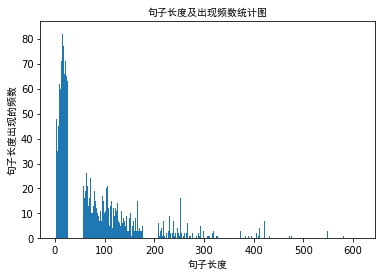

[0.007471398552416531, 0.018678496381041326, 0.026850338547746905, 0.03502218071445248, 0.044594910109736166, 0.055101564324071914, 0.06537473733364464, 0.07985057202895167, 0.09526033154331076, 0.10926920382909176, 0.12631333177679196, 0.14289049731496614, 0.16226943731029653, 0.1814148961008639, 0.19915946766285314, 0.2171375204296054, 0.23534905440112072, 0.25075881391547983, 0.2659350922250759, 0.28251225776325006, 0.2997898669157133, 0.31496614522530936, 0.3301424235349054, 0.3448517394349755, 0.3586271305159935, 0.36983422834461827, 0.380340882558954, 0.39271538641139386, 0.40205463460191454, 0.4111604015876722, 0.4235349054401121, 0.43450852206397383, 0.44454821386878357, 0.4522530936259631, 0.4604249357926687, 0.4688302591641373, 0.4763016577165538, 0.48517394349754844, 0.49661452253093624, 0.5022180714452487, 0.5094559887929022, 0.5178613121643708, 0.5276675227644174, 0.5337380340882559, 0.5423768386644875, 0.548680831193089, 0.5538174176978753, 0.5594209666121878, 0.563623628

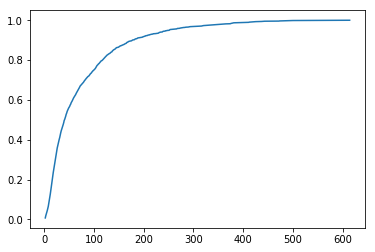

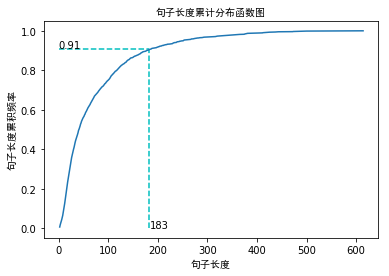

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from itertools import accumulate

# 设置matplotlib绘图时的字体
my_font=font_manager.FontProperties(fname="C:\Windows\Fonts\simhei.ttf")

# 统计句子长度及长度出现的频数
df=pd.read_csv('./data.csv')
print(df.groupby('label')['label'].count())

df['length']=df['evaluation'].apply(lambda x:len(x))
len_df=df.groupby('length').count()
sent_length=len_df.index.tolist()
sent_freq=len_df['evaluation'].tolist()

# 绘制句子长度及出现频数统计图
plt.bar(sent_length,sent_freq)
plt.title('句子长度及出现频数统计图',fontproperties=my_font)
plt.xlabel('句子长度',fontproperties=my_font)
plt.ylabel('句子长度出现的频数',fontproperties=my_font)
plt.show()
plt.close()
# 绘制句子长度累积分布函数(CDF)
sent_pentage_list=[(count/sum(sent_freq)) for count in accumulate(sent_freq)]

# 绘制CDF
plt.plot(sent_length,sent_pentage_list)

# 寻找分位点为quantile的句子长度
quantile=0.91
print(list(sent_pentage_list))
for length,per in zip(sent_length,sent_pentage_list):
    if round(per,2)==quantile:
        index=length
        break
print('\n分位点维%s的句子长度：%d.'%(quantile,index))

plt.show()
plt.close()

# 绘制句子长度累积分布函数图
plt.plot(sent_length,sent_pentage_list)
plt.hlines(quantile,0,index,colors='c',linestyles='dashed')
plt.vlines(index,0,quantile,colors='c',linestyles='dashed')
plt.text(0,quantile,str(quantile))
plt.text(index,0,str(index))
plt.title('句子长度累计分布函数图',fontproperties=my_font)
plt.xlabel('句子长度',fontproperties=my_font)
plt.ylabel('句子长度累积频率',fontproperties=my_font)
plt.show()
plt.close()


LSTM

In [3]:
import pickle
import numpy as np
import pandas as pd
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Embedding,Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# load dataset
# ['evaluation'] is feature, ['label'] is label
def load_data(filepath,input_shape=20):
    df=pd.read_csv(filepath)

    # 标签及词汇表
    labels,vocabulary=list(df['label'].unique()),list(df['evaluation'].unique())

    # 构造字符级别的特征
    string=''
    for word in vocabulary:
        string+=word

    vocabulary=set(string)

    # 字典列表
    word_dictionary={word:i+1 for i,word in enumerate(vocabulary)}
    with open('word_dict.pk','wb') as f:
        pickle.dump(word_dictionary,f)
    inverse_word_dictionary={i+1:word for i,word in enumerate(vocabulary)}
    label_dictionary={label:i for i,label in enumerate(labels)}
    with open('label_dict.pk','wb') as f:
        pickle.dump(label_dictionary,f)
    output_dictionary={i:labels for i,labels in enumerate(labels)}

    # 词汇表大小
    vocab_size=len(word_dictionary.keys())
    # 标签类别数量
    label_size=len(label_dictionary.keys())

    # 序列填充，按input_shape填充，长度不足的按0补充
    x=[[word_dictionary[word] for word in sent] for sent in df['evaluation']]
    x=pad_sequences(maxlen=input_shape,sequences=x,padding='post',value=0)
    y=[[label_dictionary[sent]] for sent in df['label']]
    '''
    np_utils.to_categorical用于将标签转化为形如(nb_samples, nb_classes)
    的二值序列。
    假设num_classes = 10。
    如将[1, 2, 3,……4]转化成：
    [[0, 1, 0, 0, 0, 0, 0, 0]
     [0, 0, 1, 0, 0, 0, 0, 0]
     [0, 0, 0, 1, 0, 0, 0, 0]
    ……
    [0, 0, 0, 0, 1, 0, 0, 0]]
    '''
    y=[np_utils.to_categorical(label,num_classes=label_size) for label in y]
    y=np.array([list(_[0]) for _ in y])

    return x,y,output_dictionary,vocab_size,label_size,inverse_word_dictionary

# 创建深度学习模型，Embedding + LSTM + Softmax
def create_LSTM(n_units,input_shape,output_dim,filepath):
    x,y,output_dictionary,vocab_size,label_size,inverse_word_dictionary=load_data(filepath)
    model=Sequential()
    model.add(Embedding(input_dim=vocab_size+1,output_dim=output_dim,
                        input_length=input_shape,mask_zero=True))
    model.add(LSTM(n_units,input_shape=(x.shape[0],x.shape[1])))
    model.add(Dropout(0.2))
    model.add(Dense(label_size,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    '''
        error:ImportError: ('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
        版本问题：from keras.utils.vis_utils import plot_model
        真正解决方案：https://www.pianshen.com/article/6746984081/
    '''

    plot_model(model,to_file='./model_lstm.png',show_shapes=True)
    # 输出模型信息
    model.summary()

    return model

# 模型训练
def model_train(input_shape,filepath,model_save_path):
    # 将数据集分为训练集和测试集，占比为9：1
    # input_shape=100
    x,y,output_dictionary,vocab_size,label_size,inverse_word_dictionary=load_data(filepath,input_shape)
    train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.1,random_state=42)

    # 模型输入参数，需要根据自己需要调整
    n_units=100
    batch_size=32
    epochs=5
    output_dim=20

    # 模型训练
    lstm_model=create_LSTM(n_units,input_shape,output_dim,filepath)
    lstm_model.fit(train_x,train_y,epochs=epochs,batch_size=batch_size,verbose=1)
    # 模型预测
    y_predict=lstm_model.predict(test_x)

    # 模型保存
    lstm_model.save(model_save_path)

    # 测试条数
    N= test_x.shape[0]
    predict=[]
    label=[]
    for start,end in zip(range(0,N,1),range(1,N+1,1)):
        print(f'start:{start}, end:{end}')
        sentence=[inverse_word_dictionary[i] for i in test_x[start] if i!=0]
        y_predict=lstm_model.predict(test_x[start:end])
        print('y_predict:',y_predict)
        label_predict=output_dictionary[np.argmax(y_predict[0])]
        label_true=output_dictionary[np.argmax(test_y[start:end])]
        print(f'label_predict:{label_predict}, label_true:{label_true}')
        # 输出预测结果
        print(''.join(sentence),label_true,label_predict)
        predict.append(label_predict)
        label.append(label_true)

    # 预测准确率
    acc=accuracy_score(predict,label)
    print('模型在测试集上的准确率:%s'%acc)

if __name__=='__main__':
    filepath='./data.csv'
    input_shape=180
    model_save_path='./model_lstm.h5'
    model_train(input_shape,filepath,model_save_path)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 180, 20)           43120     
_________________________________________________________________
lstm (LSTM)                  (None, 100)               48400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 91,722
Trainable params: 91,722
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
121/121 [==============================] - 13s 84ms/step - loss: 0.462